In [2]:
import xarray as xr
import wrf
from netCDF4 import Dataset
import numpy as np
import glob
import hvplot.xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import tqdm
import pyart
import datetime as dt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


0.3.0


In [3]:
#Load WRF output files
wrflist = [Dataset(f) for f in np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa/sfcwind*d04*"))]
times = wrf.extract_times(wrflist,wrf.ALL_TIMES)

In [4]:
#Look at available variables
wrflist[0].variables.keys()

dict_keys(['Times', 'XLAT', 'XLONG', 'U10', 'V10', 'XTIME', 'WSPD10MAX'])

In [ ]:
#Extract U10 and V10 variables, and calculate 10 m wind speed
u10 = wrf.getvar(wrflist, "U10", timeidx=wrf.ALL_TIMES, method="cat")
v10 = wrf.getvar(wrflist, "V10", timeidx=wrf.ALL_TIMES, method="cat")
ws = np.sqrt(np.square(u10) + np.square(v10))

In [ ]:
ws_max = wrf.getvar(wrflist, "WSPD10MAX", timeidx=wrf.ALL_TIMES, method="cat")

In [ ]:
#From the underway data directory, load navigation info
underway_data_path = "/g/data/w40/ab4502/IN2023_V06/data/underway/"
fnames = ["20231014-213337-shipnav-shipnav_01.nav","20231015-093337-shipnav-shipnav_01.nav","20231015-213338-shipnav-shipnav_01.nav"]
underway_nav = xr.open_mfdataset([underway_data_path+s for s in fnames])[["lat","long"]]

#Extract ship lat/lon at WRF output times
ship_lons = []
ship_lats = []
for t in tqdm.tqdm(range(ws.Time.shape[0])):
    current_nav = underway_nav.sel(time=ws.isel(Time=t).Time.values,method="nearest")
    ship_lat, ship_lon = current_nav.lat.values, current_nav.long.values
    ship_lats.append(float(ship_lat))
    ship_lons.append(float(ship_lon))

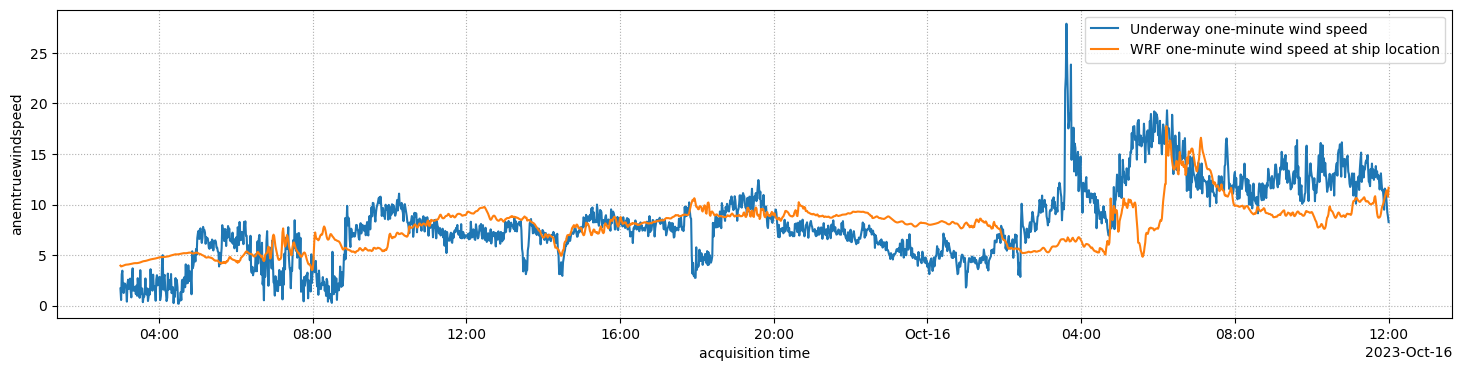

In [8]:
#Compare ship wind measurements with WRF wind field at the same points.

ship_x, ship_y = wrf.ll_to_xy(wrflist,ship_lats,ship_lons).values
target_x = xr.DataArray(ship_x,dims="points")
target_y = xr.DataArray(ship_y,dims="points")
ws_points = ws.sel(south_north=target_y, west_east=target_x).values
ws_max_points = ws_max.sel(south_north=target_y, west_east=target_x).values

plt.figure(figsize=[18,4])
underway_data_path = "/g/data/w40/ab4502/IN2023_V06/data/underway/"

fnames = ["20231014-213339-weather-met_01.met","20231015-093340-weather-met_01.met","20231015-213339-weather-met_01.met","20231016-093341-weather-met_01.met"]
underway_weather = xr.open_mfdataset([underway_data_path+s for s in fnames])
(underway_weather["anemtruewindspeed"]/1.94384).sel(time=times,method="nearest").plot(label="Underway one-minute wind speed")

plt.plot(times,[ws_points[t,t] for t in range(ws_points.shape[0])],label="WRF one-minute wind speed at ship location")
plt.plot(times,[ws_max_points[t,t] for t in range(ws_points.shape[0])],label="WRF one-minute max wind speed at ship location")
plt.gca().grid(ls=":")

#plt.plot(times,ws.max(("south_north","west_east")).values,label="WRF one-minute wind speed domain max",ls=":",color="tab:orange")

plt.legend()

In [50]:
def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)

        R = 6373.0

        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

i=0
wrf_lats = wrf.getvar(wrflist, "XLAT", timeidx=0).values
wrf_lons = wrf.getvar(wrflist, "XLONG", timeidx=0).values
dist = np.stack([latlon_dist(ship_lats[i], ship_lons[i], wrf_lats, wrf_lons) for i in (range(len(ship_lats)))])
ws_mask = ws.where(dist<=50,np.nan)

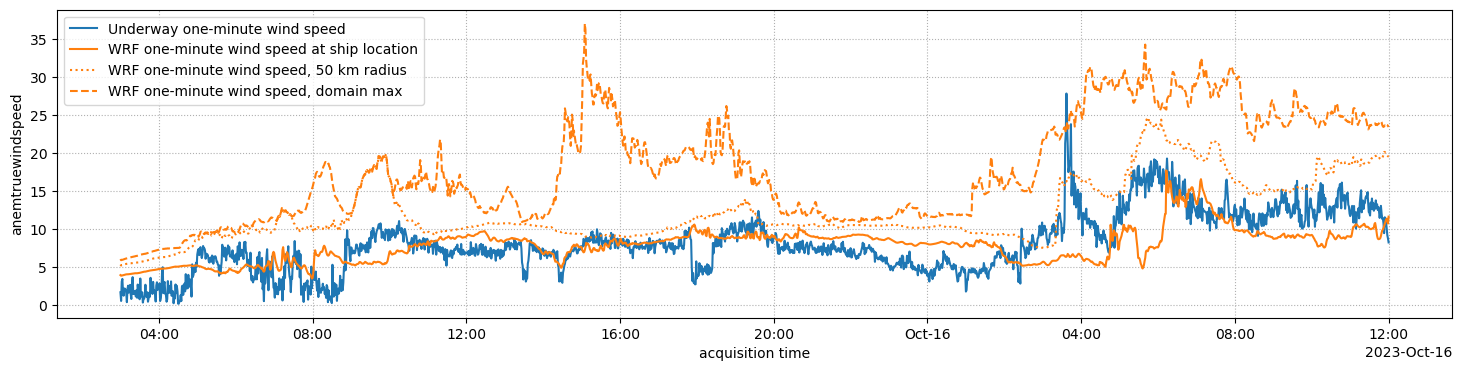

In [50]:
plt.figure(figsize=[18,4])
underway_data_path = "/g/data/w40/ab4502/IN2023_V06/data/underway/"

fnames = ["20231014-213339-weather-met_01.met","20231015-093340-weather-met_01.met","20231015-213339-weather-met_01.met","20231016-093341-weather-met_01.met"]
underway_weather = xr.open_mfdataset([underway_data_path+s for s in fnames])
(underway_weather["anemtruewindspeed"]/1.94384).sel(time=times,method="nearest").plot(label="Underway one-minute wind speed")

plt.plot(times,[ws_points[t,t] for t in range(ws_points.shape[0])],label="WRF one-minute wind speed at ship location")
plt.gca().grid(ls=":")

plt.plot(times,ws_mask.max(("south_north","west_east")).values,label="WRF one-minute wind speed, 50 km radius",ls=":",color="tab:orange")

plt.plot(times,ws.max(("south_north","west_east")).values,label="WRF one-minute wind speed, domain max",ls="--",color="tab:orange")

plt.legend()